# Project Submission: NLP Modeling

Student names: Qi Cai, Alex Karadjov

Student pace: full time

Instructor name: David B. Elliott

### Business Problem: 
 Extract useful information from tweets for Apple products to highlight areas for improvements.
 
 Create a model to successfully predict whether a tweet has positive or negative sentiments for Apple Product.

### Stakeholders: Apple Marketing and Product Development Teams



In [11]:
#import neccessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import nltk
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
import string

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import label_binarize

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, roc_curve, auc
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score

# import libraries for imbalanced class 
from imblearn.pipeline import Pipeline as ImPipeline
from imblearn.over_sampling import SMOTE


In [12]:
#load cleaned dataset
df = pd.read_csv("./Data/Cleaned_tweet_dataset.csv")

## Binary Classification Simple Model

Start with a binary classification simple model only consider positive and negative sentiments as the target.

In [28]:
# Create a new dataframe for binary classification and focus on Apple product
df_binary = df [(df['Emotion'] != 'Neutral') & (df['Brand'] == 'Apple')]

In [31]:
# Checking out the first few rows of the datafram
df_binary.head() 

,Unnamed: 0,Tweet,Brand/Product,Emotion,Brand
0,0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative,Apple
1,1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive,Apple
2,2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive,Apple
3,3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative,Apple
7,8,Beautifully smart and simple idea RT @madebyma...,iPad or iPhone App,Positive,Apple


In [32]:
#binarizing emotion column
emotion_dict = {'Negative': 0, 'Positive': 1} # setting negative to 0, and positive to 1
df_binary['Emotion'] = df_binary['Emotion'].map(emotion_dict)


<ipython-input-32-27e6c32fe092>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_binary['Emotion'] = df_binary['Emotion'].map(emotion_dict)


In [33]:
df_binary['Emotion'].value_counts(normalize= True)

1    0.836149
0    0.163851
Name: Emotion, dtype: float64

we got class imbalance in our dataset so will use SMOTE to increase minority counts

### Start the modeling process

In [34]:
# Define X, y
X = df_binary['Tweet'] # Tweet content is our feature
y = df_binary['Emotion'] #binary target for negative and positive emotions

# Train-test-split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42) # split data into training and testing


### Dummy Classifier for baseline to evaluate other model performances

In [35]:
# Instantiate tweet tokenizer to later include in the pipeline
tokenizer = TweetTokenizer()

In [36]:
# Create a list of stopwords, based on the eda notebook.
stop_lst = stopwords.words('english') + list(string.punctuation) + ['...','#sxsw', '’', '#sxswi', 'sxsw', "''", 'link','rt'] + ['ipad', 'apple', 'google', 'iphone', '#apple', 
                               '#google', '#ipad', '#iphone', 'android']
# included punctuations and product/company names

In [37]:
# Create a dummy pipeline 
dummy_pipe = ImPipeline([('vectorizer', TfidfVectorizer(tokenizer=tokenizer.tokenize, 
                                        stop_words=stop_lst)), # NLP preprocessing: tokenize, remove stopwords, punctunations, lowercase
                     ('smote', SMOTE(sampling_strategy = 1, random_state = 42)), # use SMOTE to get 1:1 ratio for both classes
                     ('dumm', DummyClassifier(random_state=42))]) # first attempt: dummy classifier

dummy_pipe.fit(X_train, y_train)

/Users/echocai/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...],
                                 tokenizer=<bound method TweetTokenizer.tokenize of <nltk.tokenize.casual.TweetTokenizer object at 0x7fa07589b5b0>>)),
                ('smote', SMOTE(random_state=42, sampling_strategy=1)),
                ('dumm', DummyClassifier(random_state=42))])

In [38]:
# predict target with dummy_pipe on testing set
y_pred = dummy_pipe.predict(X_test)
# print a classification report
print (classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.18      1.00      0.30       112
           1       0.00      0.00      0.00       525

    accuracy                           0.18       637
   macro avg       0.09      0.50      0.15       637
weighted avg       0.03      0.18      0.05       637



/Users/echocai/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/echocai/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/echocai/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [39]:
# check accuracy of the dummy model
accuracy_score(y_test, y_pred)

0.17582417582417584

In [40]:
# Check out confusion matrix
cm1 = confusion_matrix(y_test,y_pred)
cm1

array([[112,   0],
       [525,   0]])

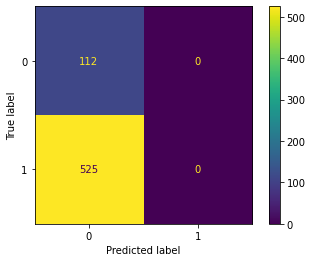

In [41]:
# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm1)
disp.plot()
plt.show()

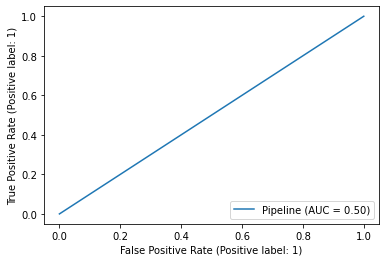

In [42]:
RocCurveDisplay.from_estimator( dummy_pipe, X_test, y_test )

### This dummy classifier model performs very bad with a 0.176 accuracy. AUC score of 0.5. Will see how random forest perform with similar pipeline steps!

## Random Forest Baseline Model

In [43]:
# Create a pipeline for random forest.
rfc_pipe = ImPipeline([('vectorizer', TfidfVectorizer(tokenizer=tokenizer.tokenize, 
                                                    stop_words=stop_lst)), # NLP preprocessing: tokenize, remove stopwords, punctunations, lowercase
                     ('smote', SMOTE(sampling_strategy = 1, random_state = 42)), # use SMOTE to get 1:1 ratio for both classes
                     ('rfc', RandomForestClassifier(random_state=42))]) # first attempt: Random forest classifier

rfc_pipe.fit(X_train, y_train) 

/Users/echocai/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...],
                                 tokenizer=<bound method TweetTokenizer.tokenize of <nltk.tokenize.casual.TweetTokenizer object at 0x7fa07589b5b0>>)),
                ('smote', SMOTE(random_state=42, sampling_strategy=1)),
                ('rfc', RandomForestClassifier(random_state=42))])

In [44]:
y_pred = rfc_pipe.predict(X_test)
print (classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.31      0.46       112
           1       0.87      0.99      0.93       525

    accuracy                           0.87       637
   macro avg       0.86      0.65      0.69       637
weighted avg       0.87      0.87      0.84       637



In [45]:
accuracy_score(y_test, y_pred)

0.869701726844584

In [46]:
recall_score(y_test, y_pred)

0.9885714285714285

In [47]:
cm2 = confusion_matrix(y_test,y_pred)
cm2

array([[ 35,  77],
       [  6, 519]])

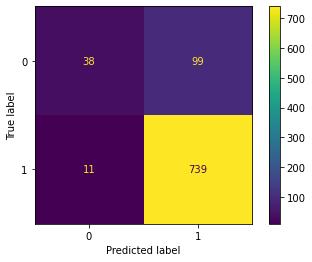

In [59]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm2)
disp.plot()
plt.show()

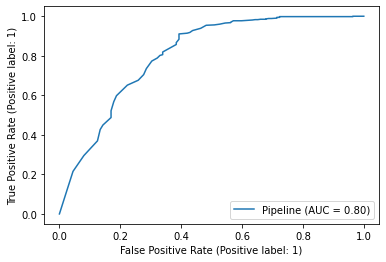

In [48]:
RocCurveDisplay.from_estimator( rfc_pipe, X_test, y_test )

Comparing this baseline random forest model with dummy model, this one performs much better with an accuracy of 0.870
and an AUC score of 0.80. However, the recall score indicates that it's only to predict negative tweets at 31% correctly. This model can predict the positive tweets at 99% correct. Will tune the model to see if we can improve these scores.

# Perform GridSearch on random forest

In [49]:
params = {}
params['rfc__criterion'] = ['gini', 'entropy']
params['rfc__max_depth'] = [10, 20, None]
params['rfc__min_samples_leaf'] = [1,2,3]
params['vectorizer__norm']: ['l1','l2']


gs_rfc = GridSearchCV(estimator= rfc_pipe,
                 param_grid=params,
                 scoring='recall_macro',
                 n_jobs = 2,
                 verbose= 3)


In [50]:
gs_rfc.fit(X_train, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


/Users/echocai/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


GridSearchCV(estimator=Pipeline(steps=[('vectorizer',
                                        TfidfVectorizer(stop_words=['i', 'me',
                                                                    'my',
                                                                    'myself',
                                                                    'we', 'our',
                                                                    'ours',
                                                                    'ourselves',
                                                                    'you',
                                                                    "you're",
                                                                    "you've",
                                                                    "you'll",
                                                                    "you'd",
                                                                    'your',
                                                                    'yours',
                                                                    'yourself',
                                                                    'yourselves',
                                                                    'he', 'him',
                                                                    'his',
                                                                    'himself',
                                                                    'she',
                                                                    "she's",
                                                                    'her',
                                                                    'hers',
                                                                    'herself',
                                                                    'it',
                                                                    "it's",
                                                                    'its',
                                                                    'itself', ...],
                                                        tokenizer=<bound method TweetTokenizer.tokenize of <nltk.tokenize.casual.TweetTokenizer object at 0x7fa07589b5b0>>)),
                                       ('smote',
                                        SMOTE(random_state=42,
                                              sampling_strategy=1)),
                                       ('rfc',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=2,
             param_grid={'rfc__criterion': ['gini', 'entropy'],
                         'rfc__max_depth': [10, 20, None],
                         'rfc__min_samples_leaf': [1, 2, 3]},
             scoring='recall_macro', verbose=3)

In [51]:
gs_rfc.best_params_

{'rfc__criterion': 'entropy', 'rfc__max_depth': 10, 'rfc__min_samples_leaf': 1}

Making a new pipeline for Random Forest with best parameters from gripsearch:

In [52]:
rfc_best_pipe = ImPipeline([('vectorizer', TfidfVectorizer(tokenizer=tokenizer.tokenize, 
                                                    stop_words=stop_lst)), # NLP preprocessing: tokenize, remove stopwords, punctunations, lowercase
                     ('smote', SMOTE(sampling_strategy = 1, random_state = 42)), # use SMOTE to get 1:1 ratio for both classes
                     ('rfc', RandomForestClassifier(criterion = 'entropy',
                                                    max_depth = 10,
                                                    min_samples_leaf = 1,
                                                    random_state = 42))]) # revised based on best_params

rfc_best_pipe.fit(X_train, y_train) 

/Users/echocai/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...],
                                 tokenizer=<bound method TweetTokenizer.tokenize of <nltk.tokenize.casual.TweetTokenizer object at 0x7fa07589b5b0>>)),
                ('smote', SMOTE(random_state=42, sampling_strategy=1)),
                ('rfc',
                 RandomForestClassifier(criterion='entropy', max_depth=10,
                                        random_state=42))])

In [53]:
y_pred = rfc_best_pipe.predict(X_test)
print (classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.68      0.34      0.45       112
           1       0.87      0.97      0.92       525

    accuracy                           0.86       637
   macro avg       0.78      0.65      0.68       637
weighted avg       0.84      0.86      0.84       637



In [56]:
accuracy_score(y_test, y_pred)

0.8555729984301413

In [57]:
recall_score(y_test, y_pred)

0.9657142857142857

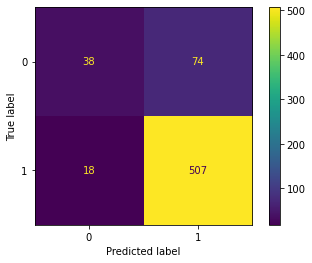

In [54]:
cm3 = confusion_matrix(y_test,y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm3)
disp.plot()
plt.show()


This model decreases false positive rate but it also increases a bit on false negative rate as well.

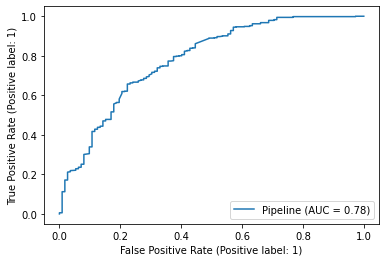

In [55]:
RocCurveDisplay.from_estimator( rfc_best_pipe, X_test, y_test )

### AUC 0.78 is less than the baseline random forest model. This model decreases false positive rate but it also increases a bit on false negative rate as well. So far, the 1st random forest model works the best overall.

## 1st logistic regression model

In [58]:
# Create a pipeline for a baseline logistic regression model
logreg_pipe = ImPipeline([
    ('vectorizer', TfidfVectorizer(tokenizer=tokenizer.tokenize, 
                                   stop_words=stop_lst)), 
    ('smote', SMOTE(sampling_strategy = 1, random_state = 42)),
    ('lr', LogisticRegression(random_state=42))
])

logreg_pipe.fit(X_train, y_train)

/Users/echocai/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...],
                                 tokenizer=<bound method TweetTokenizer.tokenize of <nltk.tokenize.casual.TweetTokenizer object at 0x7fa07589b5b0>>)),
                ('smote', SMOTE(random_state=42, sampling_strategy=1)),
                ('lr', LogisticRegression(random_state=42))])

In [59]:
y_pred = logreg_pipe.predict(X_test)

In [60]:
print (classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.66      0.56      0.61       112
           1       0.91      0.94      0.92       525

    accuracy                           0.87       637
   macro avg       0.78      0.75      0.76       637
weighted avg       0.86      0.87      0.87       637



In [61]:
accuracy_score(y_test, y_pred)

0.8712715855572999

In [62]:
recall_score(y_test, y_pred)

0.9371428571428572

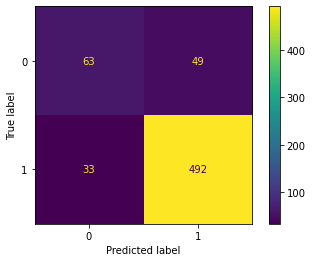

In [65]:
cm4 = confusion_matrix(y_test,y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm4)
disp.plot()
plt.show()

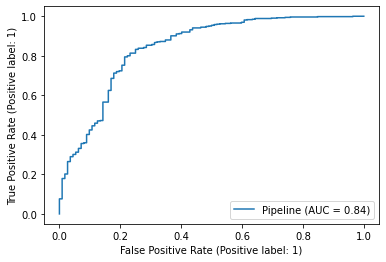

In [64]:
RocCurveDisplay.from_estimator(logreg_pipe , X_test, y_test )

### Comparing this baseline logistic regression model with baseline random forest model, this one performs much better!!! With a recall of 0.56 predicting negative sentiments correctly! Also with higher AUC score. And a 1% higher accuracy score!

# Perform GridSearch on Logistic Regression

In [66]:
params = {}
params['lr__class_weight'] = ['balanced']
params['lr__max_iter'] = [100, 200, 300, 500, 700,1000]
params['lr__C'] = [0.01, 0.1, 1]
params['lr__solver']: ['liblinear', 'lbfgs', 'sag','saga', 'newton-cholesky']



gs_logreg = GridSearchCV(estimator=logreg_pipe, 
                              param_grid = params, 
                              scoring='accuracy')


In [67]:
gs_logreg.fit(X_train,  y_train)
gs_logreg.best_params_

/Users/echocai/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/echocai/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/echocai/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/echocai/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/echocai/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:528: UserWarn

/Users/echocai/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/echocai/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/echocai/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/echocai/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/echocai/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:528: UserWarn

/Users/echocai/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/echocai/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/echocai/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/echocai/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/echocai/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:528: UserWarn

{'lr__C': 1, 'lr__class_weight': 'balanced', 'lr__max_iter': 100}

# Tuned Logistic Regression Model with best parameters from gridSeach

In [68]:
# 'lr__C': 1, 'lr__class_weight': 'balanced', 'lr__max_iter': 100
# Create a pipeline for a best tuned logistic regression model
logreg_best_pipe = ImPipeline([
    ('vectorizer', TfidfVectorizer(tokenizer=tokenizer.tokenize, 
                                   stop_words=stop_lst)), 
    ('smote', SMOTE(sampling_strategy = 1, random_state = 42)),
    ('lr', LogisticRegression(random_state=42,
                             C = 1,
                             class_weight = 'balanced',
                             max_iter = 100))
])

logreg_best_pipe.fit(X_train, y_train)

/Users/echocai/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...],
                                 tokenizer=<bound method TweetTokenizer.tokenize of <nltk.tokenize.casual.TweetTokenizer object at 0x7fa07589b5b0>>)),
                ('smote', SMOTE(random_state=42, sampling_strategy=1)),
                ('lr',
                 LogisticRegression(C=1, class_weight='balanced',
                                    random_state=42))])

In [69]:
y_pred = logreg_best_pipe.predict(X_test)

In [70]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.66      0.56      0.61       112
           1       0.91      0.94      0.92       525

    accuracy                           0.87       637
   macro avg       0.78      0.75      0.76       637
weighted avg       0.86      0.87      0.87       637



In [71]:
accuracy_score(y_test, y_pred)

0.8712715855572999

In [72]:
recall_score(y_test, y_pred)

0.9371428571428572

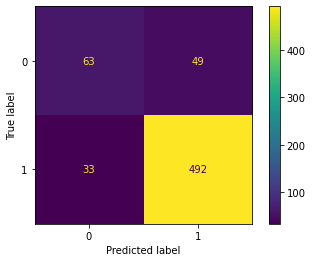

In [73]:
cm5 = confusion_matrix(y_test,y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm5)
disp.plot()
plt.show()


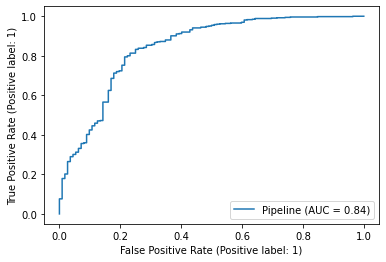

In [74]:
RocCurveDisplay.from_estimator(logreg_best_pipe , X_test, y_test )


This result this very similar to the baseline logistic regression.

both with accuracy of 0.87 and recall of 0.94.

Best model would be my base logistic regression.

## Logistic regression model has the best results. With an accuracy of 0.87, recall of 0.94, AUC score of 0.84.

### Our strategies include using: TfidfVectorizer, SMOTE, and Logistic regression model with best parameters of C =1, class_weight = 'balanced', max_iter = 100